<a href="https://colab.research.google.com/github/kaluznys/uczenie_maszynowe_UW/blob/main/praca_domowa_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

In [3]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.43MB/s]


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # start tensors: 28x28x1
        # Convolutional layer 1: in_channels=1, out_channels=6, kernel_size=5
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        #tensor after: 28x28x6

        # Subsampling layer 1: 2x2 average pooling
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 14x14x6

        # Convolutional layer 2: in_channels=6, out_channels=16, kernel_size=5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        #tensor after: 10x10x16

        # Subsampling layer 2: 2x2 average pooling
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # input from previous feature map
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))   # Conv1 + Tanh
        x = self.pool1(x)           # Pool1
        x = torch.sigmoid(self.conv2(x))   # Conv2 + Tanh
        x = self.pool2(x)           # Pool2
        x = x.view(-1, 16 * 5 * 5)  # Flatten
        x = torch.sigmoid(self.fc1(x))     # FC1 + Tanh
        x = torch.sigmoid(self.fc2(x))     # FC2 + Tanh
        x = self.fc3(x)             # Output layer (logits)
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(16):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.329209089279175
epoch: 0 batch: 1 current batch loss: 2.3151423931121826
epoch: 0 batch: 2 current batch loss: 2.3034250736236572
epoch: 0 batch: 3 current batch loss: 2.3030223846435547
epoch: 0 batch: 4 current batch loss: 2.299583911895752
epoch: 0 batch: 5 current batch loss: 2.3067140579223633
epoch: 0 batch: 6 current batch loss: 2.305943489074707
epoch: 0 batch: 7 current batch loss: 2.305669069290161
epoch: 0 batch: 8 current batch loss: 2.304302930831909
epoch: 0 batch: 9 current batch loss: 2.304661273956299
epoch: 0 batch: 10 current batch loss: 2.3001327514648438
epoch: 0 batch: 11 current batch loss: 2.3010499477386475
epoch: 0 batch: 12 current batch loss: 2.3018860816955566
epoch: 0 batch: 13 current batch loss: 2.3023409843444824
epoch: 0 batch: 14 current batch loss: 2.302072286605835
epoch: 0 batch: 15 current batch loss: 2.3032138347625732
epoch: 0 batch: 16 current batch loss: 2.3007724285125732
epoch: 0 batch:

# Testing
----------------------

In [5]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9374


In [6]:
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def dream_digits_l2(model, num_steps=600, lr=0.1, lambda_l2=1.0):
    target_labels = torch.arange(10, device=device)
    dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

    optimizer = torch.optim.Adam([dreamed_images], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(dreamed_images)
        ce_loss = loss_fn(output, target_labels)

        # L2 kara (kwadraty wart. pixeli)
        l2_penalty = dreamed_images.pow(2).mean()
        loss = ce_loss + lambda_l2 * l2_penalty

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = F.softmax(output, dim=1)
            confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
            history.append(confidence)

        if step % 50 == 0 or step == num_steps - 1:
            print(f"Step {step} | CE Loss: {ce_loss.item():.4f} | L2: {l2_penalty.item():.4f} | Mean Conf: {np.mean(confidence):.4f}")

    final_images = dreamed_images.clone().detach().cpu().squeeze()
    return final_images, np.array(history)

cuda


Step 0 | CE Loss: 4.1975 | L2: 0.9951 | Mean Conf: 0.1585
Step 50 | CE Loss: 0.0152 | L2: 1.4600 | Mean Conf: 0.9849
Step 100 | CE Loss: 0.0135 | L2: 1.3114 | Mean Conf: 0.9867
Step 150 | CE Loss: 0.0127 | L2: 1.1682 | Mean Conf: 0.9874
Step 200 | CE Loss: 0.0123 | L2: 1.0448 | Mean Conf: 0.9878
Step 250 | CE Loss: 0.0120 | L2: 0.9383 | Mean Conf: 0.9880
Step 300 | CE Loss: 0.0119 | L2: 0.8458 | Mean Conf: 0.9882
Step 350 | CE Loss: 0.0117 | L2: 0.7648 | Mean Conf: 0.9884
Step 400 | CE Loss: 0.0116 | L2: 0.6936 | Mean Conf: 0.9885
Step 450 | CE Loss: 0.0115 | L2: 0.6304 | Mean Conf: 0.9886
Step 500 | CE Loss: 0.0114 | L2: 0.5742 | Mean Conf: 0.9887
Step 550 | CE Loss: 0.0113 | L2: 0.5240 | Mean Conf: 0.9888
Step 599 | CE Loss: 0.0113 | L2: 0.4800 | Mean Conf: 0.9888


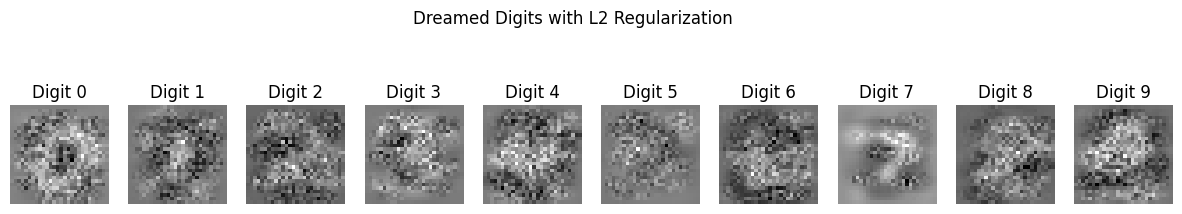

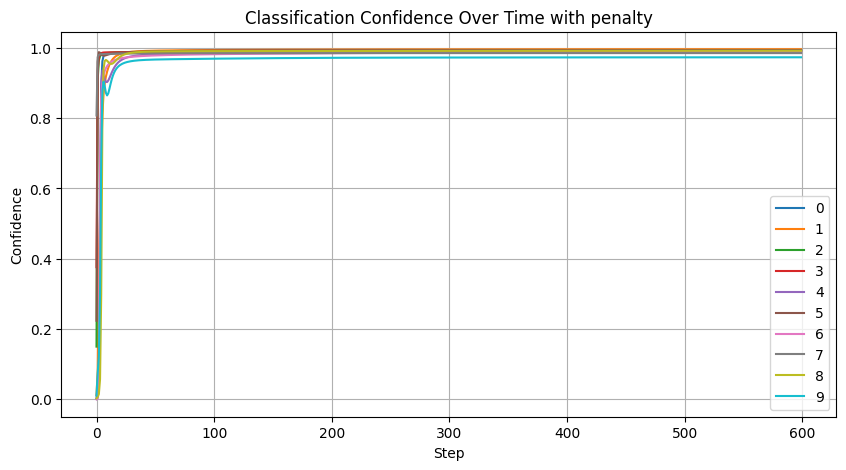

Step 0 | CE Loss: 4.9487 | L2: 0.9856 | Mean Conf: 0.0784
Step 50 | CE Loss: 0.0162 | L2: 1.0776 | Mean Conf: 0.9840
Step 100 | CE Loss: 0.0142 | L2: 0.6806 | Mean Conf: 0.9860
Step 150 | CE Loss: 0.0134 | L2: 0.4417 | Mean Conf: 0.9867
Step 200 | CE Loss: 0.0129 | L2: 0.2936 | Mean Conf: 0.9872
Step 250 | CE Loss: 0.0127 | L2: 0.2001 | Mean Conf: 0.9874
Step 300 | CE Loss: 0.0127 | L2: 0.1406 | Mean Conf: 0.9874
Step 350 | CE Loss: 0.0128 | L2: 0.1032 | Mean Conf: 0.9873
Step 400 | CE Loss: 0.0129 | L2: 0.0799 | Mean Conf: 0.9872
Step 450 | CE Loss: 0.0130 | L2: 0.0656 | Mean Conf: 0.9871
Step 500 | CE Loss: 0.0130 | L2: 0.0567 | Mean Conf: 0.9871
Step 550 | CE Loss: 0.0130 | L2: 0.0511 | Mean Conf: 0.9871
Step 599 | CE Loss: 0.0130 | L2: 0.0475 | Mean Conf: 0.9871


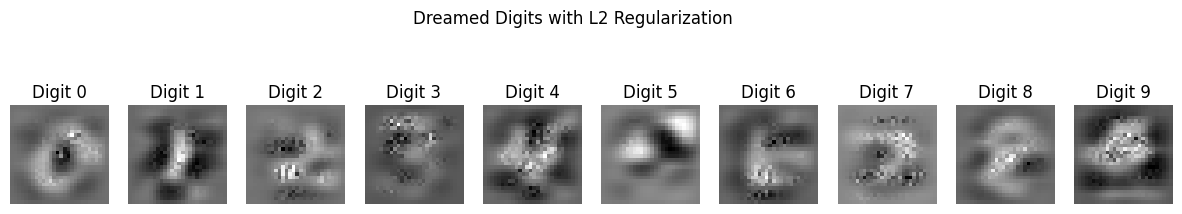

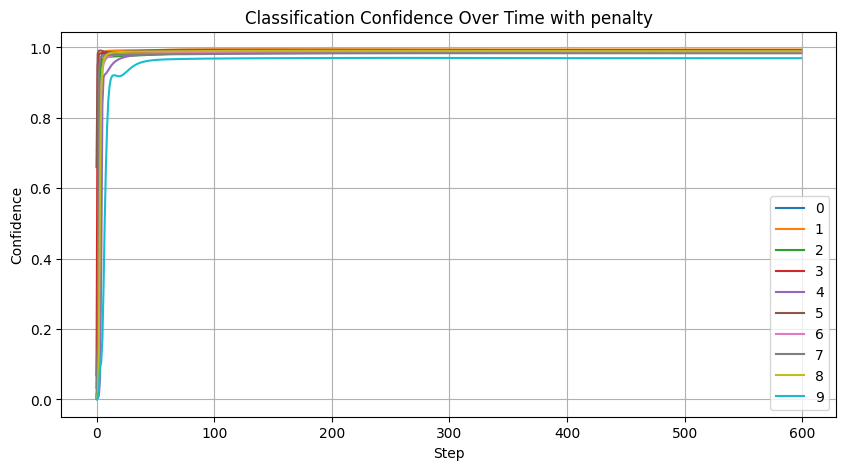

Step 0 | CE Loss: 5.1462 | L2: 1.0109 | Mean Conf: 0.1119
Step 50 | CE Loss: 0.0171 | L2: 0.2442 | Mean Conf: 0.9830
Step 100 | CE Loss: 0.0192 | L2: 0.0516 | Mean Conf: 0.9810
Step 150 | CE Loss: 0.0202 | L2: 0.0242 | Mean Conf: 0.9801
Step 200 | CE Loss: 0.0202 | L2: 0.0197 | Mean Conf: 0.9800
Step 250 | CE Loss: 0.0202 | L2: 0.0188 | Mean Conf: 0.9800
Step 300 | CE Loss: 0.0202 | L2: 0.0187 | Mean Conf: 0.9800
Step 350 | CE Loss: 0.0202 | L2: 0.0186 | Mean Conf: 0.9800
Step 400 | CE Loss: 0.0202 | L2: 0.0186 | Mean Conf: 0.9800
Step 450 | CE Loss: 0.0202 | L2: 0.0186 | Mean Conf: 0.9800
Step 500 | CE Loss: 0.0202 | L2: 0.0186 | Mean Conf: 0.9800
Step 550 | CE Loss: 0.0202 | L2: 0.0186 | Mean Conf: 0.9800
Step 599 | CE Loss: 0.0202 | L2: 0.0186 | Mean Conf: 0.9800


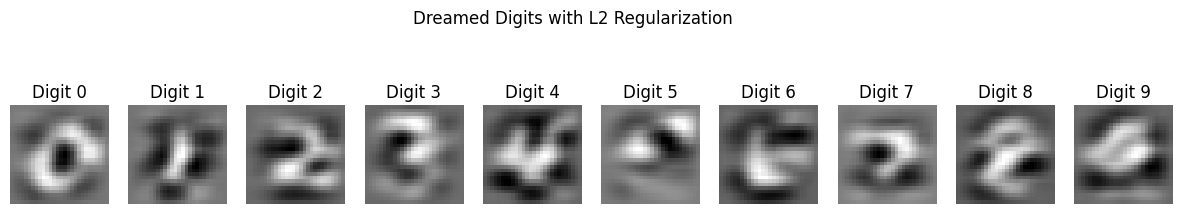

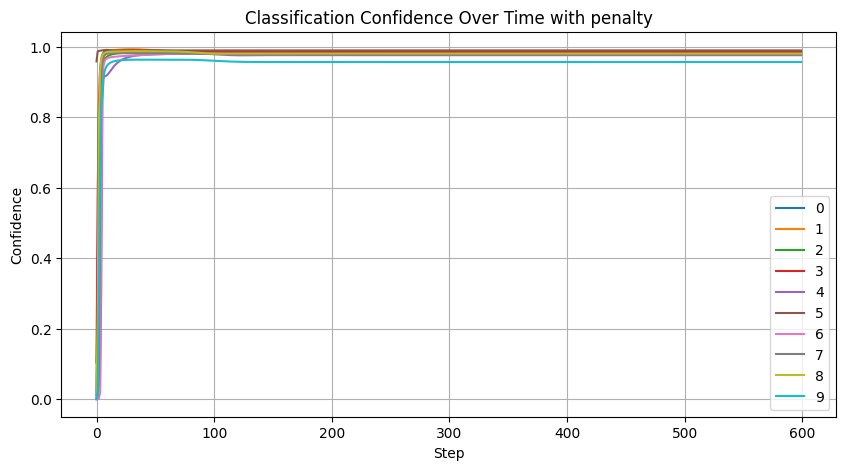

Step 0 | CE Loss: 4.3997 | L2: 0.9874 | Mean Conf: 0.1067
Step 50 | CE Loss: 0.0517 | L2: 0.0136 | Mean Conf: 0.9498
Step 100 | CE Loss: 0.0511 | L2: 0.0095 | Mean Conf: 0.9504
Step 150 | CE Loss: 0.0512 | L2: 0.0095 | Mean Conf: 0.9503
Step 200 | CE Loss: 0.0512 | L2: 0.0095 | Mean Conf: 0.9503
Step 250 | CE Loss: 0.0512 | L2: 0.0095 | Mean Conf: 0.9503
Step 300 | CE Loss: 0.0512 | L2: 0.0095 | Mean Conf: 0.9503
Step 350 | CE Loss: 0.0512 | L2: 0.0095 | Mean Conf: 0.9503
Step 400 | CE Loss: 0.0512 | L2: 0.0095 | Mean Conf: 0.9503
Step 450 | CE Loss: 0.0512 | L2: 0.0095 | Mean Conf: 0.9503
Step 500 | CE Loss: 0.0512 | L2: 0.0095 | Mean Conf: 0.9503
Step 550 | CE Loss: 0.0512 | L2: 0.0095 | Mean Conf: 0.9503
Step 599 | CE Loss: 0.0512 | L2: 0.0095 | Mean Conf: 0.9503


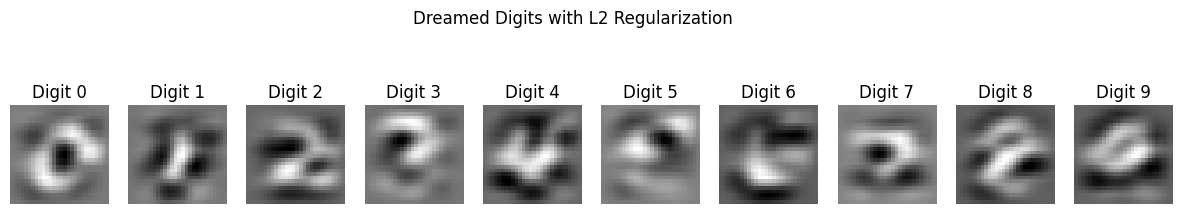

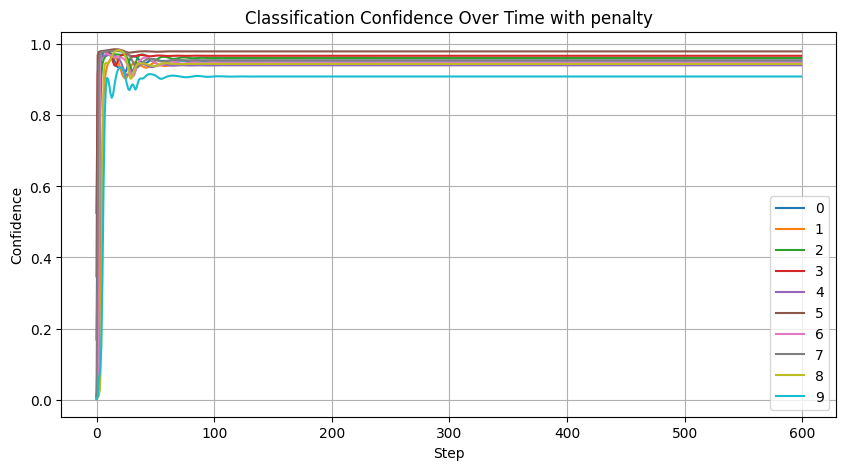

Step 0 | CE Loss: 3.6243 | L2: 0.9916 | Mean Conf: 0.1354
Step 50 | CE Loss: 0.2215 | L2: 0.0072 | Mean Conf: 0.8053
Step 100 | CE Loss: 0.2207 | L2: 0.0048 | Mean Conf: 0.8061
Step 150 | CE Loss: 0.2208 | L2: 0.0048 | Mean Conf: 0.8060
Step 200 | CE Loss: 0.2208 | L2: 0.0048 | Mean Conf: 0.8060
Step 250 | CE Loss: 0.2208 | L2: 0.0048 | Mean Conf: 0.8060
Step 300 | CE Loss: 0.2208 | L2: 0.0048 | Mean Conf: 0.8060
Step 350 | CE Loss: 0.2208 | L2: 0.0048 | Mean Conf: 0.8060
Step 400 | CE Loss: 0.2208 | L2: 0.0048 | Mean Conf: 0.8060
Step 450 | CE Loss: 0.2208 | L2: 0.0048 | Mean Conf: 0.8060
Step 500 | CE Loss: 0.2208 | L2: 0.0048 | Mean Conf: 0.8060
Step 550 | CE Loss: 0.2208 | L2: 0.0048 | Mean Conf: 0.8060
Step 599 | CE Loss: 0.2208 | L2: 0.0048 | Mean Conf: 0.8060


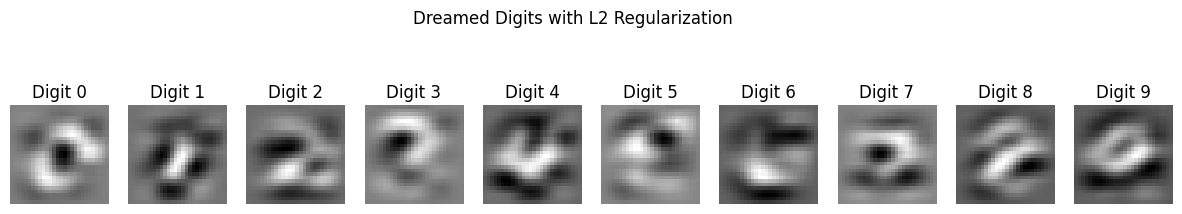

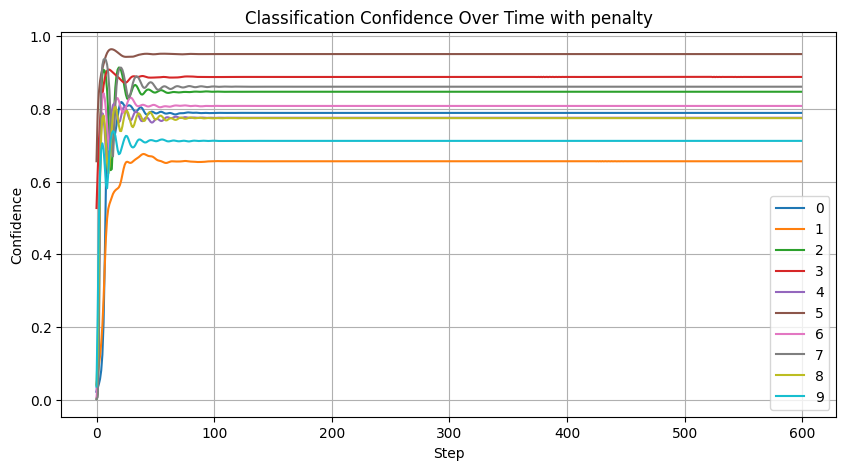

In [7]:
def plot_task3_results(images, history):

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
        ax.set_title(f"Digit {i}")
    plt.suptitle("Dreamed Digits with L2 Regularization")
    plt.show()


    history = np.array(history)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(history[:, i], label=f"{i}")
    plt.title("Classification Confidence Over Time with penalty")
    plt.xlabel("Step")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()
    # test dla różnych kar.
for lam in [0.01, 0.1, 1, 10, 100]:
  final_images, confidence_history = dream_digits_l2(net, lambda_l2=lam)

  plot_task3_results(final_images, confidence_history)